# setup & imports

In [ ]:
import json
import os

import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
from sklearn.semi_supervised import LabelPropagation
from sklearn.semi_supervised import LabelSpreading
import random
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import check_pairwise_arrays, euclidean_distances
import time
from sklearn.metrics import confusion_matrix

# visualization

In [ ]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
def plot_images(X, y):
  fig, axes = plt.subplots(ncols=7, nrows=3, figsize=(17, 8))
  
  index = 0
  for i in range(3):
      for j in range(7):
          axes[i,j].set_title(labels[y[index][0]])
          axes[i,j].imshow(X[index])
          axes[i,j].get_xaxis().set_visible(False)
          axes[i,j].get_yaxis().set_visible(False)
          index += 1
  plt.show()

# Data Import

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

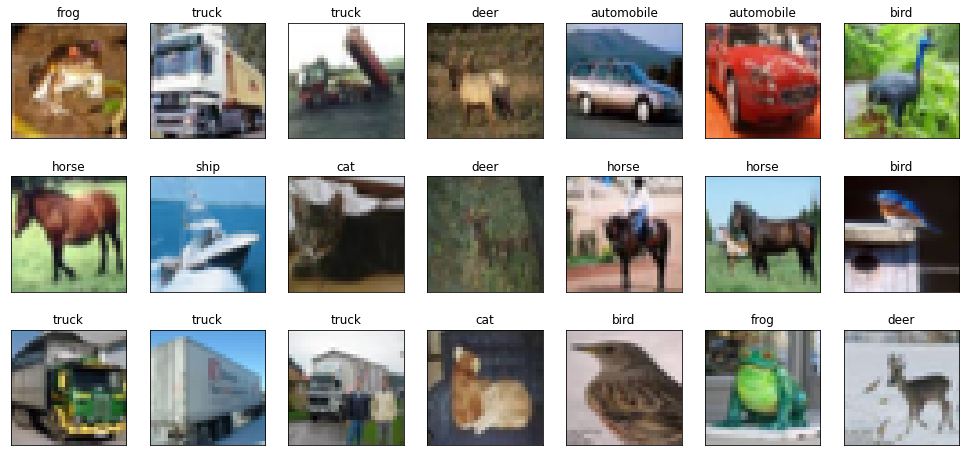

In [ ]:
X = np.concatenate((x_train, x_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)
plot_images(X, y)

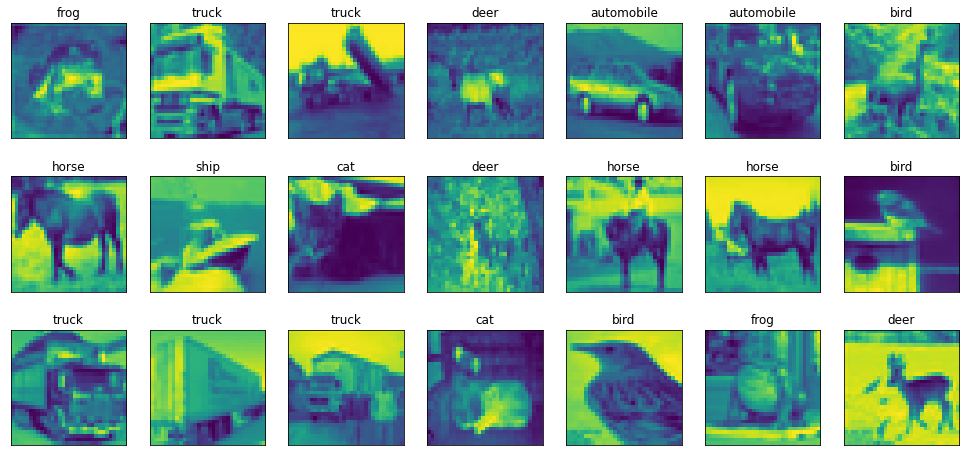

In [ ]:
# from 3 channel to 1 channel (grey scale)
X = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in X])
plot_images(X, y)

In [ ]:
# flatten
X = np.array([img.flatten() for img in X])
X.shape, y.shape

((60000, 1024), (60000, 1))

In [ ]:
_, X, _, y = train_test_split(X, y, test_size=0.2, random_state=42)
X.shape, y.shape

((12000, 1024), (12000, 1))

# Train, Validation & Test

In [ ]:
OUTER_KFOLD = 10
INNER_KFOLD = 3
N_SEARCHES = 50
CSV_LOG_PATH = 'metrics_log_Label_spreading.csv'

In [ ]:
def unlabel(X, y):
  df = pd.DataFrame(y)

  # list of np arrays
  to_keep_labeled = []
  not_labeled = []
  for lbl, grp in df.groupby(0):
    to_keep_labeled.append(grp.index.values[:10])
    # 64 per class
    not_labeled.append(grp.index.values[10:74])

  to_keep_labeled = np.hstack(to_keep_labeled) 
  X_small_labeled = X[to_keep_labeled]
  y_small_labeled = y[to_keep_labeled]

  not_labeled = np.hstack(not_labeled)
  X_not_labeled = X[not_labeled]
  y_not_labeled = np.array([np.array([-1]) for i in range(640)])
  
  X_train = np.concatenate((X_small_labeled, X_not_labeled),axis=0)
  y_train = np.concatenate((y_small_labeled, y_not_labeled),axis=0)
  
  return X_train, y_train

In [ ]:
with open(CSV_LOG_PATH, 'a') as fd:
  fd.write('dataset,algorithm_name,cross_validation,alpha,n_neighbors,acc,tpr,fpr,precision,auc,training_time (s),time_took_per_1k (s)\n')


In [ ]:
idx_outer_fold = 0
best_model_outer, best_model_top1_acc_outer = None, None
outer_cv = KFold(n_splits=OUTER_KFOLD, shuffle=True, random_state=42)

for i, (train_and_val_index, test_index) in enumerate(outer_cv.split(X)):
  X_train_and_val, X_test = X[train_and_val_index], X[test_index]
  y_train_and_val, y_test = y[train_and_val_index], y[test_index]


  best_model_inner, best_model_top1_acc_inner, best_model_training_time = None, None, None
  best_alpha, best_n_neighbors = None, None
  for search_idx in range(N_SEARCHES):
    alpha = np.random.uniform(0.1, 0.9)
    n_neighbors = int(np.random.uniform(5, 15))

    idx_inner_fold = 0
    best_model_random, best_model_top1_acc_random = None, None
    inner_cv = KFold(n_splits=INNER_KFOLD, shuffle=True, random_state=11)

    for i, (train_index, val_index) in enumerate(inner_cv.split(X_train_and_val)):
      X_train, X_val = X_train_and_val[train_index], X_train_and_val[val_index]
      y_train, y_val = y_train_and_val[train_index], y_train_and_val[val_index]

      model = LabelSpreading(kernel='knn', n_neighbors=n_neighbors, alpha=alpha)

      X_train, y_train = unlabel(X_train, y_train)

      start_fit = time.time()
      model.fit(X_train, y_train)
      end_fit = time.time()

      curr_training_time = end_fit - start_fit   # seconds

      predictions = model.predict(X_val)
      top1_acc = accuracy_score(y_val, predictions)

      if best_model_random is None or top1_acc > best_model_top1_acc_random:
        best_model_random = model
        best_model_top1_acc_random = top1_acc
        best_alpha = alpha
        best_n_neighbors = n_neighbors
        best_model_training_time = curr_training_time

      idx_inner_fold += 1

    if best_model_inner is None or best_model_top1_acc_random > best_model_top1_acc_inner:
      best_model_inner = best_model_random
      best_model_top1_acc_inner = best_model_top1_acc_random
  
  start = time.time()
  pred = best_model_inner.predict(X_test)
  end = time.time()

  prob_pred = best_model_inner.predict_proba(X_test)
  
  time_took = end - start
  pred = np.array([np.array([p]) for p in pred])
  cm=confusion_matrix(y_test, pred)
  FP = cm.sum(axis=0) - np.diag(cm)  
  FN = cm.sum(axis=1) - np.diag(cm)
  TP = np.diag(cm)
  TN = cm.sum() - (FP + FN + TP)

  FP = FP.astype(float)
  FN = FN.astype(float)
  TP = TP.astype(float)
  TN = TN.astype(float)

  tpr = np.mean(TP/(TP+FN))
  fpr = np.mean(FP/(FP+TN))
  acc = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred, average='micro')
  time_took_per_1k = time_took * (1000 / len(y_test))
  auc = roc_auc_score(y_test, prob_pred, multi_class='ovr')

  to_write = f'CIFAR10,LabelSpreading,{idx_outer_fold + 1},{best_alpha},{best_n_neighbors},{acc},{tpr},{fpr},{precision},{auc},{best_model_training_time},{time_took_per_1k}'
  with open(CSV_LOG_PATH, 'a') as fd:
    fd.write(to_write + '\n')

  print(to_write)
  idx_outer_fold += 1
  
  if best_model_outer is None or best_model_top1_acc_inner > best_model_top1_acc_outer:
    best_model_outer = best_model_inner
    best_model_top1_acc_outer = best_model_top1_acc_inner